# 1\. Data Loading and Preparation

Start by importing the essential python libraries.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # for regular expressions (used to remove URLs, punctuation, etc.).
import nltk # Natural Language Toolkit (for tokenizing text).

Load the two CSV files from data folder.

In [72]:
df_fake = pd.read_csv('../data/raw/Fake.csv')
df_real = pd.read_csv('../data/raw/True.csv')

Create the Target Variable: Assign a clear label to each dataset so I can tell them apart. This is my target variable, which I will eventually predict.

Fake News: Assign the label 0.

Real News: Assign the label 1.

In [73]:
df_fake['label'] = 0
df_real['label'] = 1

Combine DataFrames: Stack the two data sets into a single DataFrame.

Initial Inspection: Check the structure, size, and data types.

In [74]:
df = pd.concat([df_fake, df_real], ignore_index=True)
print(df.shape)
print(df.info())
print(df['label'].value_counts()) # Check for class imbalance!

(44898, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None
label
0    23481
1    21417
Name: count, dtype: int64


# 2\. Initial Data Cleaning 

Drop Unnecessary/Redundant Columns: The title and text are the primary predictive features.drop subject and date for the initial model, which can be combine them later.

In [75]:
df = df.drop(['subject', 'date'], axis=1)

Handle Duplicates: Since these are news articles, identical entries are likely mistakes. Remove all duplicates to ensure a clean dataset.

In [76]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

Check Missing Values: Confirm that no key columns (title, text, label) have missing values (NaN).

In [77]:
print(df.isnull().sum())

title    0
text     0
label    0
dtype: int64


Combine Text Fields: For the classification model, it's good to combine the information from the title and the full text into one feature.

In [78]:
df['full_text'] = df['title'] + ' ' + df['text']
df = df.drop(['title', 'text'], axis=1) # Drop the originals

## Length Analysis (Basic EDA)
Compare the physical characteristics of the articles.
1. Calculate Length Features: Create two new columns in your DataFrame:
    * word_count: The number of words in the full_text column.
    * char_count: The number of characters in the full_text column.

In [79]:
# Assuming your combined DataFrame is named 'df' and has a 'full_text' column
# and a 'label' column (0=Fake, 1=Real).

# 1. Calculate word_count
df['word_count'] = df['full_text'].apply(lambda x: len(str(x).split()))

# 2. Calculate char_count
df['char_count'] = df['full_text'].apply(lambda x: len(str(x)))

# 3. Calculate average_word_length
# We use np.divide and handle potential division by zero
df['average_word_length'] = np.divide(df['char_count'], df['word_count'], 
                                     out=np.zeros_like(df['char_count'], dtype=float), 
                                     where=df['word_count']!=0)

# Display the new columns to verify
print("New columns created. Sample rows:")
print(df[['full_text', 'word_count', 'char_count', 'average_word_length']].head())

New columns created. Sample rows:
                                           full_text  word_count  char_count  \
0   Donald Trump Sends Out Embarrassing New Year’...         507        2973   
1   Drunk Bragging Trump Staffer Started Russian ...         313        1968   
2   Sheriff David Clarke Becomes An Internet Joke...         595        3688   
3   Trump Is So Obsessed He Even Has Obama’s Name...         458        2853   
4   Pope Francis Just Called Out Donald Trump Dur...         431        2417   

   average_word_length  
0             5.863905  
1             6.287540  
2             6.198319  
3             6.229258  
4             5.607889  


2. Visualize and Compare

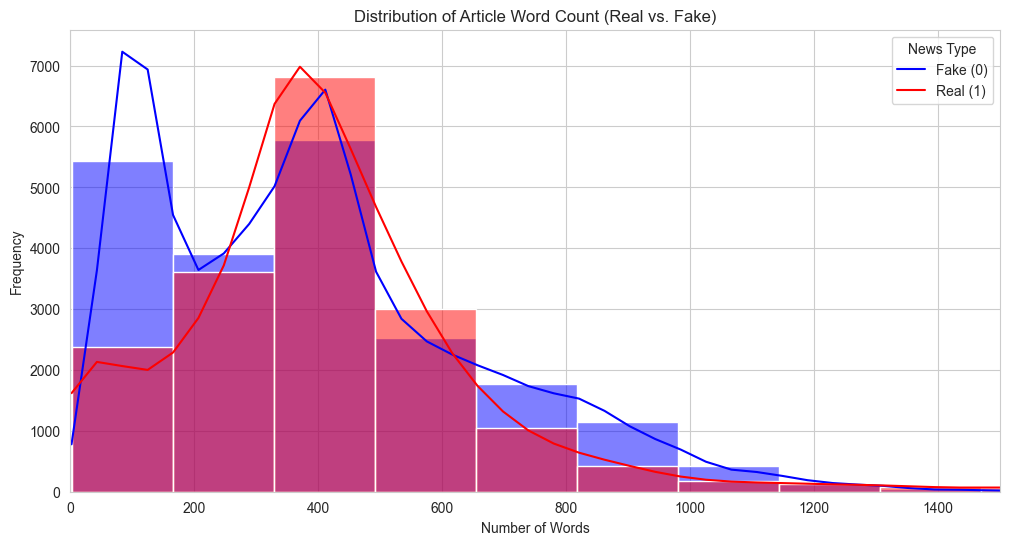

<Figure size 800x600 with 0 Axes>

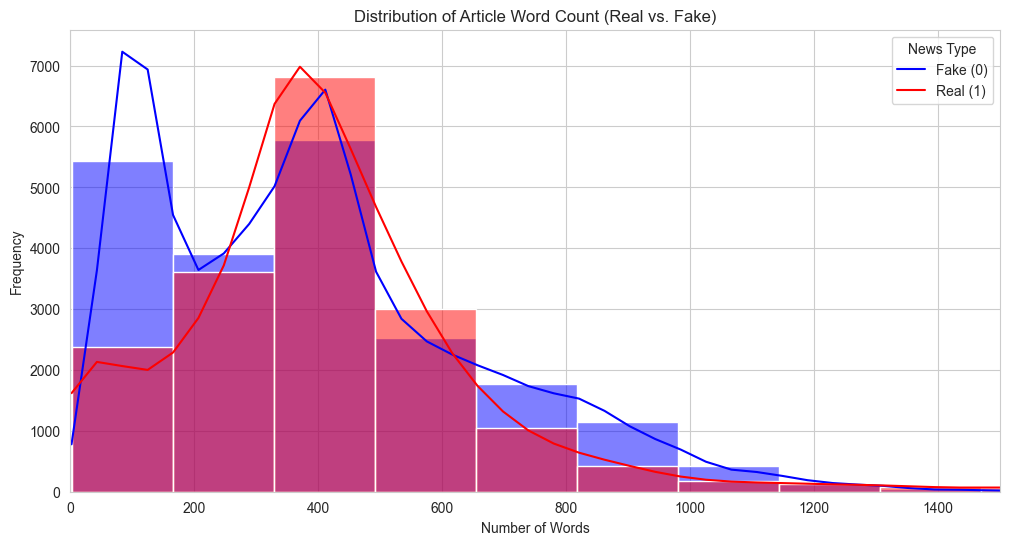

/var/folders/l1/1sv1l1yd1nd026dfs6yvtd3h0000gn/T/ipykernel_30149/2714295735.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='average_word_length', data=df,


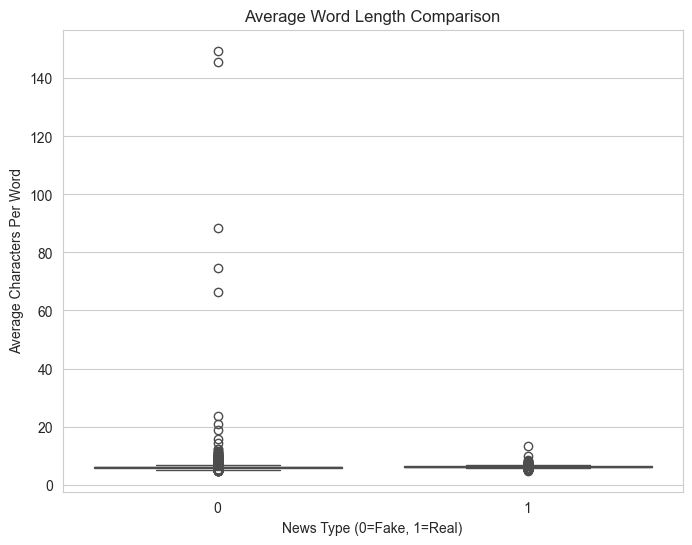


--- Quantitative Summary ---
Word Count:
         count        mean         std  min    25%    50%    75%     max
label                                                                   
0      17908.0  429.015077  357.153684  2.0  279.0  385.0  514.0  8148.0
1      21197.0  394.814644  273.772755  4.0  157.0  368.0  533.0  5181.0

Average Word Length:
         count      mean       std       min       25%       50%       75%  \
label                                                                        
0      17908.0  6.064511  1.819096  4.777778  5.782906  5.985091  6.217221   
1      21197.0  6.215182  0.264402  4.841689  6.047820  6.204846  6.369565   

              max  
label              
0      149.500000  
1       13.148084  


In [80]:
# 1. Calculate Length Features
df['word_count'] = df['full_text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['full_text'].apply(lambda x: len(str(x)))

# 2. Calculate average_word_length
df['average_word_length'] = np.divide(df['char_count'], df['word_count'], 
                                     out=np.zeros_like(df['char_count'], dtype=float), 
                                     where=df['word_count']!=0)

# 3. Visualization and Comparison

# A. Word Count Comparison
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='label', 
             palette={0: 'red', 1: 'blue'}, 
             kde=True, bins=50)

plt.title('Distribution of Article Word Count (Real vs. Fake)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 1500)
plt.legend(title='News Type', labels=['Fake (0)', 'Real (1)'])
plt.show()
# 

# B. Average Word Length Comparison
plt.figure(figsize=(8, 6))
# Fix: Change keys from integer (0, 1) to string ('0', '1')
# However, the simplest way is to ensure the label column is an integer type.

# Recommended Fix: Ensure the 'label' column is integer (if it was somehow converted to object/string earlier)
df['label'] = df['label'].astype(int)

# Use the original palette with integer keys
palette_map = {0: 'red', 1: 'blue'}

# --- Rerun the Visualization ---
df['label'] = df['label'].astype(str)

# 2. Define the palette with string keys '0' and '1'
palette_map_str = {'0': 'red', '1': 'blue'} 

# A. Word Count Comparison
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='label', 
             palette=palette_map_str, # Using string palette
             kde=True, bins=50)

plt.title('Distribution of Article Word Count (Real vs. Fake)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 1500) 
plt.legend(title='News Type', labels=['Fake (0)', 'Real (1)'])
plt.show()

# B. Average Word Length Comparison
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='average_word_length', data=df, 
            palette=palette_map_str) # Using string palette

plt.title('Average Word Length Comparison')
plt.xlabel('News Type (0=Fake, 1=Real)')
plt.ylabel('Average Characters Per Word')
plt.show()

# C. Quantitative Summary
print("\n--- Quantitative Summary ---")
print("Word Count:")
print(df.groupby('label')['word_count'].describe())
print("\nAverage Word Length:")
print(df.groupby('label')['average_word_length'].describe())

## Most Frequent Words (Word-Level EDA, Word Clouds)

This is a key step for text classification.
1. Generate Word Clouds:
    * Create a single large string containing all text from the Fake News articles.
    * Create a single large string containing all text from the Real News articles.
    * Generate and display a Word Cloud for each class. The words that appear largest are the most frequent.
    * Insight: Look for political names, proper nouns, or highly emotional words that stand out in one cloud but not the other.

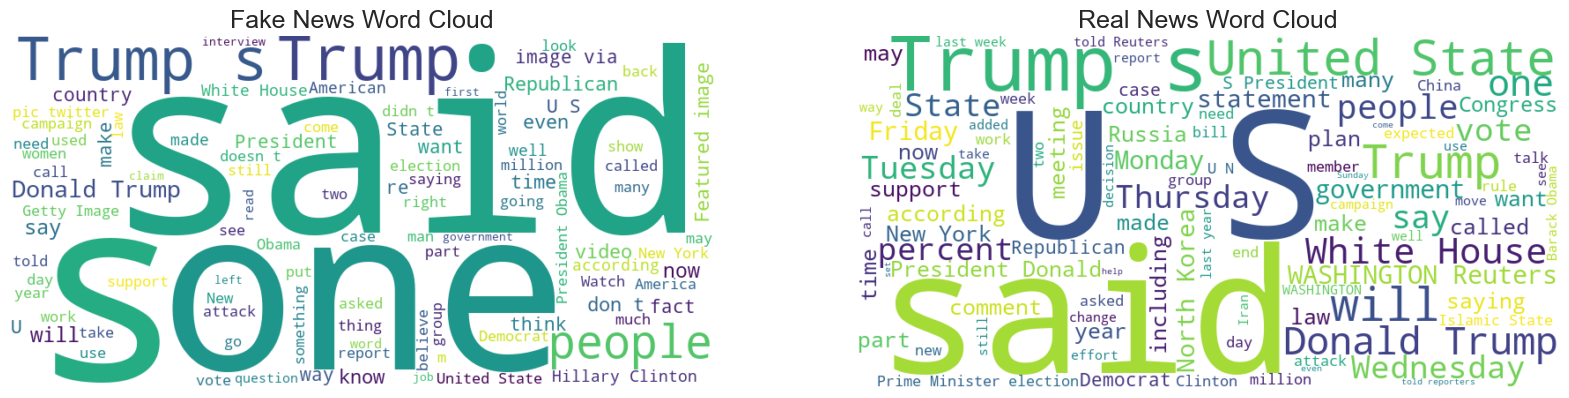

In [81]:
# --- Word-Level EDA with Word Clouds ---
from wordcloud import WordCloud, STOPWORDS
# Assuming 'df' is your combined DataFrame with 'full_text' and 'label' (as strings '0'/'1')

# 1. Group the text data by label
# We use .astype(str) to be safe against mixed types
fake_text = " ".join(df[df['label'] == '0']['full_text'].astype(str))
real_text = " ".join(df[df['label'] == '1']['full_text'].astype(str))

# 2. Create a figure for both clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 10))


# 3. Word Cloud for Fake News
wordcloud_fake = WordCloud(
    width=800, height=400, background_color='white', 
    max_words=100, 
    stopwords=STOPWORDS
).generate(fake_text)
axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Fake News Word Cloud', fontsize=18)

# 4. Word Cloud for Real News
wordcloud_real = WordCloud(
    width=800, height=400, background_color='white', 
    max_words=100, 
    stopwords=STOPWORDS 
).generate(real_text)
axes[1].imshow(wordcloud_real, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Real News Word Cloud', fontsize=18)

plt.show()
plt.show()
# [Image of Word Clouds comparing fake and real news]

## Text Normalization and Preprocessing
Advanced Text Preprocessing (The P&S Bridge)
Before vectorizing the text for the model, it must be systematically clean it to ensure accuracy.

A. Normalization Pipeline
Create a dedicated Python function (you could put this in src/text_cleaner.py) to handle the text cleaning systematically. The function should perform:
1. Case Conversion: Convert all text to lowercase.
2. Punctuation Removal: Remove all punctuation (e.g., .,!?"').
3. Special Character Removal: Remove anything that isn't a letter or number (e.g., HTML tags, extra white space).


In [82]:
# Download the required resources for your text cleaner function
# 'stopwords' is needed for the list of common words.
# 'wordnet' is needed for the WordNetLemmatizer.
# 'punkt' is needed for tokenization.

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

print("NLTK resources downloaded. You can now proceed with text cleaning.")

NLTK resources downloaded. You can now proceed with text cleaning.


[nltk_data] Downloading package stopwords to /Users/mintt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mintt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mintt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [86]:
import sys
import os

# --- Add Project Root to Path ---
# Go up one directory (from 'notebooks' to the project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Only add the path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Successfully added {project_root} to system path.")
# --------------------------------

# Now, run your import:
from src.text_cleaner import normalize_text 

# The rest of your code to apply the function:
df['cleaned_text'] = df['full_text'].apply(normalize_text, lemmatize=True, remove_stopwords=True)

print("\nRaw vs. Cleaned Text Sample:")
print(df[['full_text', 'cleaned_text']].head())

NameError: name 'pd' is not defined